Loading and Merging on Index...
Corrected MAPE (No Calib): nan%
Corrected MAPE (Calib):    nan%


IndexError: index 0 is out of bounds for axis 0 with size 0

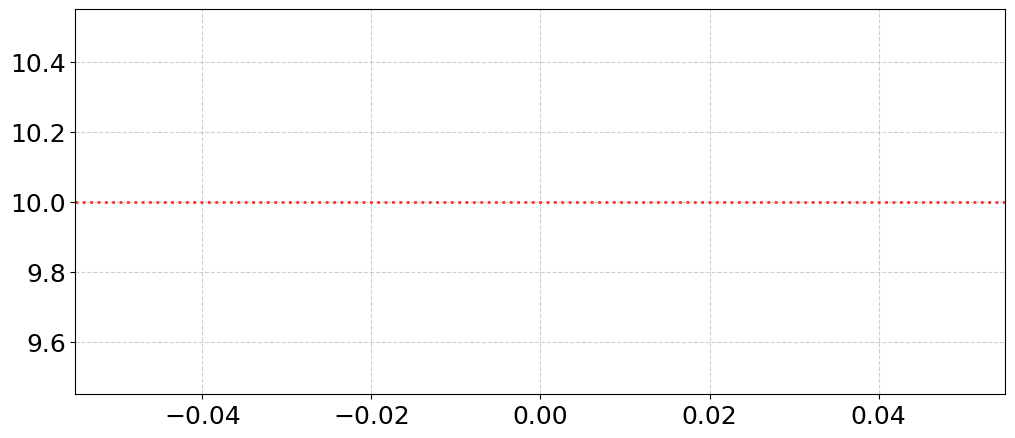

In [6]:
# # Experiment 2: Calibration Analysis (Standard 5-min Granularity)
# - **Resolution:** 5-minute intervals (same as Experiment 1).
# - **Visuals:** Includes NFR Threshold (10%) dotted line.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import os

# --- CONFIGURATION ---
COLOR_PALETTE = [
    "#0072B2",  # Ground Truth (Blue)
    "#E69F00",  # No Calibration (Orange)
    "#009E73",  # Calibration (Green)
]
METRIC = "power_draw"
ROLLING_WINDOW = 12  # 1 hour smoothing (12 * 5min)

# Standardize fonts
plt.rcParams.update({'font.size': 18})


# --- 1. DATA LOADING & ALIGNMENT (Standard 5-min) ---
def load_and_process_data_standard():
    """Aligns data to 5-minute intervals (Matches Exp 1)."""
    print("Loading data...")

    path_nc = "../data/opendt_no_calibration.parquet"
    path_c = "../data/opendt_calibration.parquet"
    path_rw = "../data/real_world.parquet"

    # Load grouped by timestamp sum
    df_nc = pd.read_parquet(path_nc).groupby("timestamp")[METRIC].sum()
    df_c = pd.read_parquet(path_c).groupby("timestamp")[METRIC].sum()
    df_rw = pd.read_parquet(path_rw).groupby("timestamp")[METRIC].sum()

    print(f"Original lengths -> NC: {len(df_nc)}, C: {len(df_c)}, RW: {len(df_rw)}")

    # --- Alignment Logic (Standard 5-min) ---
    def average_every_n(series, n):
        return series.groupby(np.arange(len(series)) // n).mean()

    # Apply Downsampling to 5 minutes
    # OpenDT (~2.5m) -> 2 samples = 5 min
    df_nc = average_every_n(df_nc, 2)
    df_c = average_every_n(df_c, 2)

    # Real World (~30s) -> 10 samples = 5 min
    df_rw = average_every_n(df_rw, 10)

    # Sync lengths (Trim to shortest)
    min_len = min(len(df_nc), len(df_c), len(df_rw))
    df_nc = df_nc.iloc[:min_len]
    df_c = df_c.iloc[:min_len]
    df_rw = df_rw.iloc[:min_len]

    # Force Start Time (5-min frequency)
    start_time = pd.Timestamp("2022-10-06 22:00:00")
    timestamps = pd.date_range(start=start_time, periods=min_len, freq="5min")

    df_nc.index = timestamps
    df_c.index = timestamps
    df_rw.index = timestamps

    print(f"Aligned length: {min_len}")
    return df_nc, df_c, df_rw, timestamps


df_nc, df_c, df_rw, timestamps = load_and_process_data_standard()


# --- 2. STATS CALCULATION ---
def calculate_ape_series(ground_truth, simulation):
    """Calculates Absolute Percentage Error (APE) series."""
    R = ground_truth.values
    S = simulation.values
    mask = R != 0
    ape = np.zeros_like(R)
    ape[mask] = np.abs((R[mask] - S[mask]) / R[mask]) * 100
    return pd.Series(ape, index=ground_truth.index)


# Calculate MAPE Series
ape_nc = calculate_ape_series(df_rw, df_nc)
ape_c = calculate_ape_series(df_rw, df_c)

# Smoothing
mape_nc_smooth = ape_nc.rolling(window=ROLLING_WINDOW, min_periods=1).mean()
mape_c_smooth = ape_c.rolling(window=ROLLING_WINDOW, min_periods=1).mean()

print(f"MAPE (No Calib): {ape_nc.mean():.2f}%")
print(f"MAPE (Calib):    {ape_c.mean():.2f}%")

# --- 3. PLOT 1: MAPE OVER TIME WITH NFR THRESHOLD ---
fig, ax = plt.subplots(figsize=(12, 5))
plt.grid(True, linestyle='--', alpha=0.6)

# Plot Rolling MAPE
ax.plot(mape_nc_smooth.index, mape_nc_smooth,
        label="No Calibration", color=COLOR_PALETTE[1], lw=2, linestyle="--")
ax.plot(mape_c_smooth.index, mape_c_smooth,
        label="With Calibration", color=COLOR_PALETTE[2], lw=2.5)

# --- ADD NFR THRESHOLD LINE ---
ax.axhline(y=10, color='red', linestyle=':', linewidth=2, alpha=0.8)
# Position text slightly above the line, near the start
ax.text(mape_nc_smooth.index[int(len(mape_nc_smooth) * 0.02)], 10.8,
        "NFR Threshold (10%)", color='red', fontsize=16, fontweight='bold')

# Formatting
ax.set_ylabel("MAPE [%]", fontsize=22, labelpad=10)
ax.set_xlabel("Time [day/month]", fontsize=22, labelpad=10)

# X-Axis Dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Y-Axis limit
ax.set_ylim(0, max(mape_nc_smooth.max(), mape_c_smooth.max()) * 1.15)

# Legend
leg = ax.legend(fontsize=18, loc="upper right", framealpha=1, ncol=1)
for line in leg.get_lines():
    line.set_linewidth(4.0)

plt.tight_layout()
plt.savefig("exp2_plot_mape_standard.pdf", format="pdf", bbox_inches="tight")
plt.show()

# --- 4. PLOT 2: POWER DRAW COMPARISON ---
fig, ax = plt.subplots(figsize=(12, 5))
plt.grid(True)

# Plot Raw Data (kW) - Thin lines
ax.plot(df_rw.index, df_rw.values / 1000,
        label="Ground Truth", color=COLOR_PALETTE[0], lw=1)
ax.plot(df_nc.index, df_nc.values / 1000,
        label="No Calibration", color=COLOR_PALETTE[1], lw=1, linestyle="--")
ax.plot(df_c.index, df_c.values / 1000,
        label="With Calibration", color=COLOR_PALETTE[2], lw=1)

# Formatting
ax.set_ylabel("Power Draw [kW]", fontsize=22, labelpad=10)
ax.set_xlabel("Time [day/month]", fontsize=22, labelpad=10)
ax.set_ylim(bottom=0)

# X-Axis Dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Y-Axis Thousands
y_formatter = FuncFormatter(lambda val, _: f"{int(val):,}")
ax.yaxis.set_major_formatter(y_formatter)

# Legend
leg = ax.legend(fontsize=18, loc="lower right", framealpha=1, ncol=3)
for line in leg.get_lines():
    line.set_linewidth(4.0)

plt.tight_layout()
plt.savefig("exp2_plot_raw_comparison_standard.pdf", format="pdf", bbox_inches="tight")
plt.show()